# Clustering
Notebook to cluster our ***video candidates for news***, i.e., videos that are flagged as possibly news related by: nyt headline comparison.

Author: Johanna

In [12]:
import pandas as pd 

#load all csv files
with open('./use_by_week_highsim_55.csv','r') as f:
    df_nyt = pd.read_csv(f)
    f.close()

In [13]:
print('nyt:',df_nyt.columns)

nyt: Index(['Unnamed: 0', 'video_id', 'video_date', 'video_keywords',
       'nyt_keywords', 'nyt_headline', 'cosine_sim'],
      dtype='object')


### Clustering
code from cs315 slides <br>
possible space for improvement: ***topic modeling***

1. hashtag clustering

## get embeddings

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
def create_embeddings(row,target):
    return embed([row[target]])

df_nyt['embeddings'] = df_nyt.apply(lambda row: create_embeddings(row,'video_keywords'), axis=1)

In [3]:
matrix_nyt = np.vstack(df_nyt['embeddings'])
print(matrix_nyt.shape)

(516, 512)


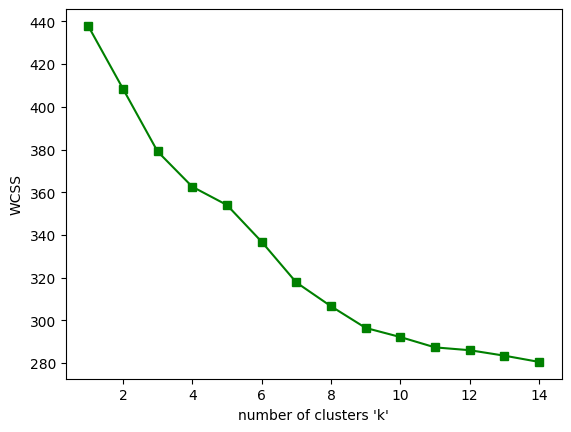

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Step 1: how do we know how many clusters to use? Elbow method!
def elbow_method(matrix, maximum_K):
  """
  Elbow Method: 
  used to figure out how many clusters we should use 
  WCSS = within-cluster sum of squares = distance between points in cluster 
  want to minimize WSS, such that WCSS is low but the clusters are small enough to interpret
  """
  wcss = {} #key: k, values: wcss

  for k in range(1,maximum_K):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
    kmeans.fit(matrix)
    wcss[k] = kmeans.inertia_

  return wcss

def draw_elbow_plot(wcss):
  plt.plot(wcss.keys(), wcss.values(), 'gs-')
  plt.xlabel("number of clusters 'k'")
  plt.ylabel('WCSS')
  plt.show()

draw_elbow_plot(elbow_method(matrix_nyt, 15))
#no clear elbow; chose 9

In [17]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.express as px
import pandas as pd

# Step 2: now that we know k=3, we can perform k-means model
def draw_cluster_plot(n_clusters,df,matrix,target,title):
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(matrix)

    df['cluster'] = kmeans.labels_

    #use TSNE to visualize high dim. data
    tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
    tsne_results = tsne.fit_transform(matrix)

    # Step 3: Append tsne_1, tsne_2 to df_hashtag
    df_tsne = pd.DataFrame(tsne_results, 
                    columns=['tsne_1', 'tsne_2'])

    df_res = pd.concat([df,df_tsne],axis=1)

    # Step 4: Use plotly to visualize it
    fig = px.scatter(df_res, x='tsne_1', y='tsne_2', color='cluster',hover_data= {target})
    fig.update_traces(textposition='top center', textfont=dict(size=6))
    fig.update_layout(title=f'Embeddings of TikTok News filtered by {title}', hoverlabel=dict(
                                    font=dict(size=7),
                                    align="left"))
    return df_res, fig

In [18]:
df_res, fig_nyt = draw_cluster_plot(9,df_nyt,matrix_nyt,'video_keywords','NYT headlines comparison')
fig_nyt

In [19]:
print("cluster 2 len:",len(df_res[df_res['cluster']==2]))
print("all len:", len(df_res))
print((71/516)*100)

cluster 2 len: 70
all len: 516
13.75968992248062
